### Import Libraries

In [33]:
import pandas as pd
import numpy as np
import os
import m2cgen
from sklearn.preprocessing import MinMaxScaler , LabelEncoder
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import joblib
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_colwidth', None)  # Show full content in each cell
pd.set_option('display.width', 1000)  # Set max width

In [2]:
path = os.getcwd().replace('notebook' , '') + 'data'
folders = os.listdir(path)[1:]
dfs = []
for folder in folders:
    folder_path = path + '/' + folder
    for file in os.listdir(folder_path):
        dfs.append(pd.read_csv(folder_path + '/' + file))
df = pd.concat(dfs, ignore_index=True)
# df = df.drop(columns="timestamp" , axis = 1)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H')
df['hour'] = df['timestamp'].dt.hour
def assign_bucket(hour):
    if 22 <= hour or hour < 8:  # 22-7 → 0
        return 0
    elif 8 <= hour < 12:        # 8-12 → 1
        return 1
    elif 12 <= hour < 17:       # 12-17 → 2
        return 2
    elif 16 <= hour <= 23:      # 16-23 → 3
        return 3

df['hour_bucket'] = df['hour'].apply(assign_bucket)
df['month'] = df['timestamp'].dt.month
def assign_season(month):
    if 11 <= month or (month>= 1 and month < 4):  # 22-7 → 0
        return 0
    elif 4 <= month < 8:        # 8-12 → 1
        return 1
    else:
        return 2
df['season'] = df['hour'].apply(assign_season)
df['day_of_week'] = df['timestamp'].dt.dayofweek 
x = df.iloc[:,1:]
y = x['AQI']
x = x.drop(columns = ['AQI'] , axis= 1)




In [3]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_train , x_test , y_train , y_test = train_test_split(x_scaled , y , test_size= 0.2)
x_train , x_val , y_train , y_val = train_test_split(x_train , y_train , test_size= 0.2)

# Encode target labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

### Random Forest

In [14]:
rf = RandomForestClassifier()

param_dist = {
    'n_estimators' : [10 , 20 , 30 , 45 , 75 , 100],
    'max_depth' : [5 , 7, 10 , 20 , 25 , 30]
    }

random_search = RandomizedSearchCV(estimator = rf,
                                    param_distributions = param_dist,
                                    cv = 5,
                                    random_state=42,
                                    n_jobs=-1
                                    )
random_search.fit(x_train, y_train)

cv_results = pd.DataFrame(random_search.cv_results_)
cv_results = cv_results[["mean_test_score", "params"]].sort_values(by="mean_test_score", ascending=False)

cv_results 

,mean_test_score,params
6,0.647405,"{'n_estimators': 45, 'max_depth': 20}"
0,0.634795,"{'n_estimators': 100, 'max_depth': 30}"
2,0.632736,"{'n_estimators': 30, 'max_depth': 25}"
5,0.628839,"{'n_estimators': 20, 'max_depth': 30}"
3,0.622176,"{'n_estimators': 10, 'max_depth': 30}"
9,0.551075,"{'n_estimators': 100, 'max_depth': 10}"
4,0.548726,"{'n_estimators': 75, 'max_depth': 10}"
1,0.546937,"{'n_estimators': 20, 'max_depth': 10}"
7,0.539626,"{'n_estimators': 10, 'max_depth': 10}"
8,0.479491,"{'n_estimators': 30, 'max_depth': 7}"


In [22]:
rf = RandomForestClassifier(n_estimators = 45 , max_depth = 20)
rf.fit(x_train , y_train)
rf.score(x_val , y_val)
rf_test_report = classification_report(rf.predict(x_test) , y_test)
print(rf_test_report)

              precision    recall  f1-score   support

           1       0.77      0.76      0.76      6712
           2       0.72      0.64      0.68     10100
           3       0.48      0.51      0.49      4723
           4       0.30      0.40      0.34      2206
           5       0.71      0.67      0.69      5752
           6       0.69      0.83      0.75      2825

    accuracy                           0.65     32318
   macro avg       0.61      0.63      0.62     32318
weighted avg       0.66      0.65      0.65     32318



In [ ]:
joblib.dump(rf, os.getcwd().replace('/notebook' , '') + "/model/random_forest_model.pkl" )
print(os.path.getsize(os.getcwd().replace('/notebook' , '') + "/model/random_forest_model.pkl" ))

189276841


#### Memory Optimization

In [65]:
rf = RandomForestClassifier(n_estimators = 10 , max_depth = 10)
rf.fit(x_train , y_train)
rf.score(x_val , y_val)
rf_report = classification_report(rf.predict(x_val) , y_val)
print(rf_report)

              precision    recall  f1-score   support

           1       0.54      0.67      0.60      4352
           2       0.75      0.46      0.57     11612
           3       0.23      0.43      0.30      2086
           4       0.04      0.52      0.07       175
           5       0.73      0.54      0.62      5760
           6       0.59      0.84      0.69      1869

    accuracy                           0.54     25854
   macro avg       0.48      0.58      0.48     25854
weighted avg       0.65      0.54      0.57     25854



In [66]:
rf_train_report = classification_report(rf.predict(x_train) , y_train)
print(rf_train_report)

              precision    recall  f1-score   support

           1       0.57      0.68      0.62     17595
           2       0.76      0.48      0.59     45807
           3       0.25      0.48      0.33      8313
           4       0.05      0.64      0.10       791
           5       0.76      0.56      0.65     23482
           6       0.61      0.87      0.72      7428

    accuracy                           0.56    103416
   macro avg       0.50      0.62      0.50    103416
weighted avg       0.67      0.56      0.59    103416



In [67]:
rf_test_report = classification_report(rf.predict(x_test) , y_test)
print(rf_test_report)

              precision    recall  f1-score   support

           1       0.55      0.66      0.60      5529
           2       0.74      0.47      0.57     14406
           3       0.23      0.43      0.30      2609
           4       0.03      0.46      0.06       223
           5       0.74      0.54      0.62      7246
           6       0.58      0.85      0.69      2305

    accuracy                           0.54     32318
   macro avg       0.48      0.57      0.48     32318
weighted avg       0.65      0.54      0.57     32318



In [68]:
with open(os.getcwd().replace('/notebook' , '') + "/model/rf_model.py" , "w") as f:
  f.write(m2cgen.export_to_python(rf))
print(os.path.getsize(os.getcwd().replace('/notebook' , '') + "/model/rf_model.py" ))

1550384


### Decision Tree

In [29]:
dt = DecisionTreeClassifier()

param_dist = {
    'max_depth' : [5 , 10 , 15 , 20 , 25 , 30 , 50, 75 , 100],
    'criterion' : ['gini' , 'entropy']
    }

random_search = RandomizedSearchCV(estimator = dt,
                                    param_distributions = param_dist,
                                    cv = 5,
                                    random_state=42,
                                    n_jobs=-1
                                    )
random_search.fit(x_train, y_train)

cv_results = pd.DataFrame(random_search.cv_results_)
cv_results = cv_results[["mean_test_score", "params"]].sort_values(by="mean_test_score", ascending=False)

cv_results 

,mean_test_score,params
4,0.587888,"{'max_depth': 20, 'criterion': 'gini'}"
5,0.585103,"{'max_depth': 25, 'criterion': 'entropy'}"
7,0.583063,"{'max_depth': 50, 'criterion': 'entropy'}"
6,0.582328,"{'max_depth': 75, 'criterion': 'entropy'}"
8,0.578808,"{'max_depth': 15, 'criterion': 'entropy'}"
3,0.576333,"{'max_depth': 30, 'criterion': 'gini'}"
9,0.576246,"{'max_depth': 15, 'criterion': 'gini'}"
2,0.575878,"{'max_depth': 100, 'criterion': 'gini'}"
1,0.508529,"{'max_depth': 10, 'criterion': 'gini'}"
0,0.426172,"{'max_depth': 5, 'criterion': 'gini'}"


In [30]:
dt = DecisionTreeClassifier(criterion = 'gini' , max_depth = 20)
dt.fit(x_train , y_train)
dt.score(x_val , y_val)
dt_test_report = classification_report(dt.predict(x_test) , y_test)
print(dt_test_report)

              precision    recall  f1-score   support

           1       0.72      0.70      0.71      6826
           2       0.64      0.60      0.62      9637
           3       0.44      0.47      0.45      4780
           4       0.32      0.34      0.33      2739
           5       0.64      0.65      0.65      5310
           6       0.68      0.76      0.72      3026

    accuracy                           0.60     32318
   macro avg       0.57      0.59      0.58     32318
weighted avg       0.61      0.60      0.60     32318



In [31]:
joblib.dump(dt, os.getcwd().replace('/notebook' , '') + "/model/decison_tree_model.pkl" )
print(os.path.getsize(os.getcwd().replace('/notebook' , '') + "/model/decison_tree_model.pkl" ))

4412025


#### Memory Optimization

In [71]:
dt = DecisionTreeClassifier(criterion = 'gini' , max_depth = 15)
dt.fit(x_train , y_train)
dt.score(x_val , y_val)
dt_report = classification_report(dt.predict(x_val) , y_val)
print(dt_report)

              precision    recall  f1-score   support

           1       0.68      0.68      0.68      5395
           2       0.68      0.56      0.62      8587
           3       0.43      0.45      0.44      3807
           4       0.25      0.38      0.30      1620
           5       0.66      0.65      0.65      4278
           6       0.66      0.82      0.73      2167

    accuracy                           0.59     25854
   macro avg       0.56      0.59      0.57     25854
weighted avg       0.61      0.59      0.60     25854



In [72]:
dt_train_report = classification_report(dt.predict(x_train) , y_train)
print(dt_train_report)

              precision    recall  f1-score   support

           1       0.75      0.73      0.74     21448
           2       0.75      0.64      0.69     33914
           3       0.55      0.57      0.56     15415
           4       0.40      0.61      0.49      6250
           5       0.77      0.76      0.76     17719
           6       0.76      0.93      0.83      8670

    accuracy                           0.69    103416
   macro avg       0.66      0.71      0.68    103416
weighted avg       0.70      0.69      0.70    103416



In [74]:
dt_test_report = classification_report(dt.predict(x_test) , y_test)
print(dt_test_report)

              precision    recall  f1-score   support

           1       0.69      0.68      0.68      6731
           2       0.66      0.56      0.61     10579
           3       0.43      0.44      0.44      4884
           4       0.26      0.37      0.30      2018
           5       0.66      0.65      0.65      5439
           6       0.65      0.83      0.73      2667

    accuracy                           0.59     32318
   macro avg       0.56      0.59      0.57     32318
weighted avg       0.61      0.59      0.60     32318



In [75]:
with open(os.getcwd().replace('/notebook' , '') + "/model/dt_model.py" , "w") as f:
  f.write(m2cgen.export_to_python(dt))
print(os.path.getsize(os.getcwd().replace('/notebook' , '') + "/model/dt_model.py" ))

1605983


### XGBoost

In [56]:
xgb = XGBClassifier()

param_dist = {
    'n_estimators' : [ 2 , 3 , 5 , 7 , 10 , 12 , 15],
    'max_depth' : [2 , 3 , 5 , 7 , 10 , 12 , 15],
    "learning_rate": [0.01, 0.3, 1]
    }

random_search = RandomizedSearchCV(estimator = xgb,
                                    param_distributions = param_dist,
                                    cv = 5,
                                    random_state=42,
                                    n_jobs=-1
                                    )
random_search.fit(x_train, y_train_encoded)

cv_results = pd.DataFrame(random_search.cv_results_)
cv_results = cv_results[["mean_test_score", "params"]].sort_values(by="mean_test_score", ascending=False)

cv_results 

/opt/anaconda3/envs/pranit/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,mean_test_score,params
2,0.632194,"{'n_estimators': 12, 'max_depth': 12, 'learning_rate': 1}"
8,0.611888,"{'n_estimators': 10, 'max_depth': 10, 'learning_rate': 0.3}"
0,0.598640,"{'n_estimators': 15, 'max_depth': 7, 'learning_rate': 1}"
7,0.557573,"{'n_estimators': 7, 'max_depth': 10, 'learning_rate': 0.01}"
6,0.556935,"{'n_estimators': 15, 'max_depth': 7, 'learning_rate': 0.3}"
4,0.478611,"{'n_estimators': 15, 'max_depth': 2, 'learning_rate': 1}"
3,0.463613,"{'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.01}"
5,0.437224,"{'n_estimators': 12, 'max_depth': 3, 'learning_rate': 0.01}"
9,0.435494,"{'n_estimators': 5, 'max_depth': 3, 'learning_rate': 0.01}"
1,0.428464,"{'n_estimators': 5, 'max_depth': 2, 'learning_rate': 0.3}"


In [35]:
xgb = XGBClassifier(n_estimators = 30 , max_depth = 20 , learning_rate = 0.3 , num_parallel_tree = 1)
xgb.fit(x_train , y_train_encoded)
xgb.score(x_val , y_val_encoded)
xgb_test_report = classification_report(label_encoder.inverse_transform(xgb.predict(x_test)) , label_encoder.inverse_transform(y_test_encoded))
print(xgb_test_report)

              precision    recall  f1-score   support

           1       0.77      0.76      0.77      6684
           2       0.71      0.65      0.68      9820
           3       0.49      0.52      0.50      4752
           4       0.34      0.41      0.38      2392
           5       0.72      0.68      0.70      5703
           6       0.72      0.81      0.76      2967

    accuracy                           0.66     32318
   macro avg       0.62      0.64      0.63     32318
weighted avg       0.66      0.66      0.66     32318



In [36]:
joblib.dump(xgb, os.getcwd().replace('/notebook' , '') + "/model/xgb_model.pkl" )
print(os.path.getsize(os.getcwd().replace('/notebook' , '') + "/model/xgb_model.pkl" ))

35459619


#### Memory Optimization

In [57]:
xgb = XGBClassifier(n_estimators = 2 , max_depth = 12 , learning_rate = 1 , num_parallel_tree = 1)
xgb.fit(x_train , y_train_encoded)
xgb.score(x_val , y_val_encoded)
xgb_report = classification_report(label_encoder.inverse_transform(xgb.predict(x_val)) , label_encoder.inverse_transform(y_val_encoded))
print(xgb_report)

              precision    recall  f1-score   support

           1       0.73      0.69      0.71      5562
           2       0.67      0.58      0.62      8447
           3       0.41      0.48      0.44      3394
           4       0.24      0.39      0.30      1418
           5       0.73      0.65      0.69      4792
           6       0.71      0.83      0.76      2241

    accuracy                           0.62     25854
   macro avg       0.58      0.60      0.59     25854
weighted avg       0.64      0.62      0.62     25854



In [58]:
xgb_train_report = classification_report(label_encoder.inverse_transform(xgb.predict(x_train)) , label_encoder.inverse_transform(y_train_encoded))
print(xgb_train_report)

              precision    recall  f1-score   support

           1       0.79      0.74      0.77     22436
           2       0.76      0.65      0.70     33512
           3       0.54      0.65      0.59     13347
           4       0.43      0.67      0.52      6069
           5       0.81      0.75      0.78     18750
           6       0.77      0.88      0.82      9302

    accuracy                           0.71    103416
   macro avg       0.68      0.72      0.70    103416
weighted avg       0.73      0.71      0.72    103416



In [59]:
xgb_test_report = classification_report(label_encoder.inverse_transform(xgb.predict(x_test)) , label_encoder.inverse_transform(y_test_encoded))
print(xgb_test_report)

              precision    recall  f1-score   support

           1       0.72      0.69      0.70      6869
           2       0.68      0.58      0.63     10623
           3       0.40      0.48      0.43      4218
           4       0.23      0.37      0.29      1836
           5       0.71      0.65      0.68      5965
           6       0.69      0.83      0.76      2807

    accuracy                           0.61     32318
   macro avg       0.57      0.60      0.58     32318
weighted avg       0.63      0.61      0.62     32318



In [60]:
with open(os.getcwd().replace('/notebook' , '') + "/model/xgb_model.py" , "w") as f:
  f.write(m2cgen.export_to_python(xgb))
print(os.path.getsize(os.getcwd().replace('/notebook' , '') + "/model/xgb_model.py" ))

2530152


### Model Accuracy Comparision

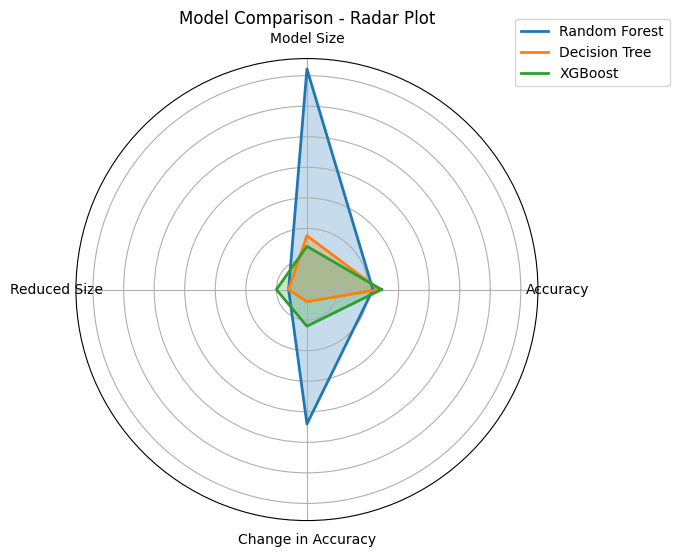

In [63]:
# Define models and values
models = {
    "Random Forest": [0.54 , 1.805, 0.15, 1.1],
    "Decision Tree": [0.59 , 0.441, 0.15, 0.1],
    "XGBoost": [0.61 , 0.354, 0.25, 0.3]
}
metrics = ["Accuracy" , "Model Size", "Reduced Size", "Change in Accuracy"]

# Convert to radians
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each model
for model, values in models.items():
    values += values[:1]  # Close the loop
    ax.plot(angles, values, label=model, linewidth=2)
    ax.fill(angles, values, alpha=0.25)  # Fill area

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.title("Model Comparison - Radar Plot")
plt.show()